In [24]:
from astropy.stats import bayesian_blocks
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18, 'figure.figsize': (14.0, 8.0)})
import numpy as np
from scipy import stats
from astropy.time import Time
from scipy import optimize, special, stats



Total bins: 140
Significant bins: 139


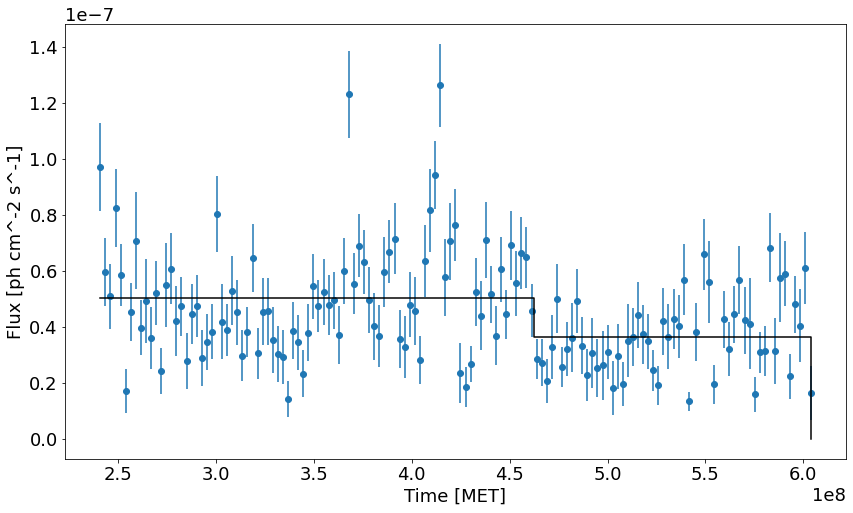

In [35]:
# Load the data, selecting only significant points
lc_file = 'data/1ES1011_monthly_lightcurve_combined.npy'
source_name = "1ES1011"


c = np.load(lc_file, allow_pickle=True, encoding='latin1').item()
good = np.array([ts > 0 if ~np.isnan(ts) else False for ts in c['ts']])
time = (c['tmin'] + c['tmax']) / 2
print("Total bins: {}".format(len(time)))
time = time[good]
print("Significant bins: {}".format(len(time)))
flux = c['flux'][good]
flux_error = c['flux_err'][good]

# Calculate the Bayesian blocks
block_edges = bayesian_blocks(time, x=flux, sigma=flux_error, fitness='measures', p0=5.73303144e-7)
block_fluxes, __, __ = stats.binned_statistic(time, flux, statistic='mean', bins=block_edges)

plt.errorbar(time, flux, yerr=flux_error, marker='o', linestyle='none')
plt.plot(block_edges, np.append(block_fluxes, 0), drawstyle='steps-post', color='k', zorder=99)
plt.xlabel('Time [MET]')
plt.ylabel("Flux [ph cm^-2 s^-1]")
plt.show()

Text(0, 0.5, 'Bins')

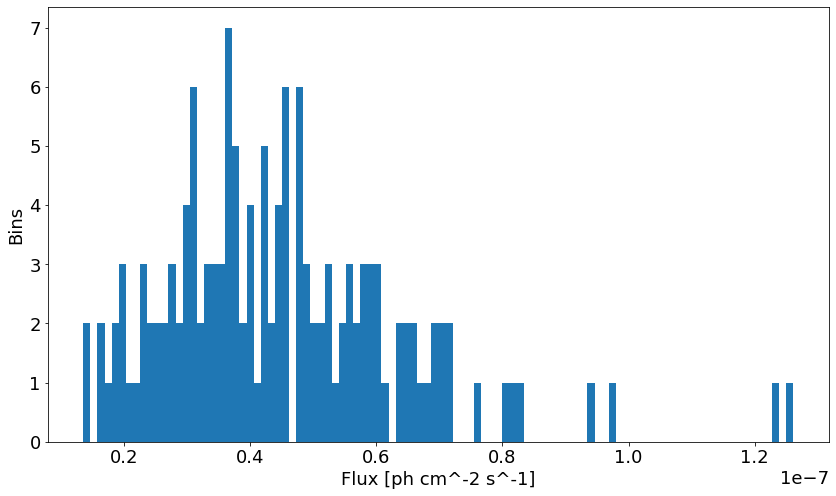

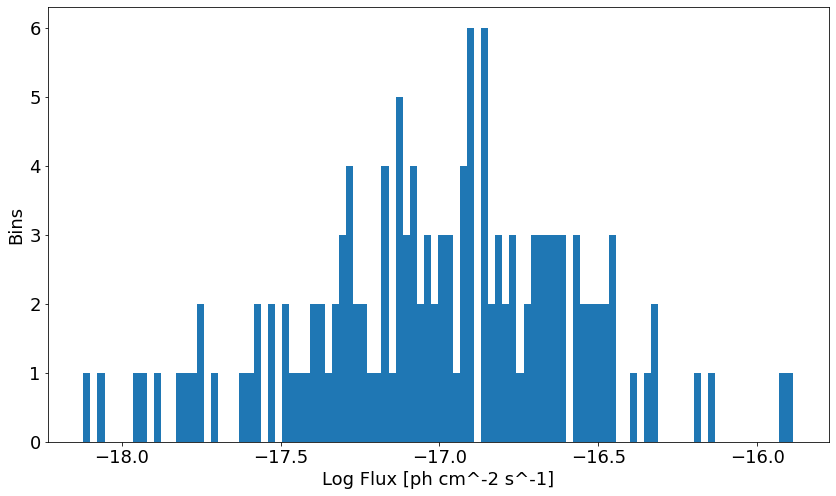

In [8]:
# Plot some flux distributions

# Plot histogram of fluxes
plt.figure()
plt.hist(flux, bins=100)
plt.xlabel("Flux [ph cm^-2 s^-1]")
plt.ylabel("Bins")

# Plot histogram of log fluxes
plt.figure()
plt.hist(np.log(flux), bins=100)
plt.xlabel("Log Flux [ph cm^-2 s^-1]")
plt.ylabel("Bins")

In [16]:

def MET2MJD(met):
    mjd_ref = 51910.#+7.428e-4
    return met*1./86400.+mjd_ref
def MJD2MET(mjd):
    mjd_ref = 51910.#+7.428e-4
    met = (mjed - mjd_ref)*86400
    return met

def get_bb_binned_v2(ts, fs, dfs, p0=0.0013, fitness='measures'):
    t_bb_slice = bayesian_blocks(ts, x=fs, 
                                 sigma=dfs, p0=p0, fitness=fitness) #, gamma=1.0)
    c_bb_slice = []
    dc_bb_slice = []

    for i in range(len(t_bb_slice)-1):
        #print(np.where((ts>=t_bb_slice[i]) & (ts<t_bb_slice[i+1])))
        #print(np.mean(fs[np.where((ts>=t_bb_slice[i]) & (ts<t_bb_slice[i+1]))]))
        slice_ind = np.where((ts>=t_bb_slice[i]) & (ts<t_bb_slice[i+1]))
        weighted_avg = np.average(fs[slice_ind], weights=1./dfs[slice_ind])
        c_bb_slice.append( weighted_avg )
        dc_bb_slice.append( np.sqrt(np.average((fs[slice_ind]-weighted_avg)**2, weights=1./dfs[slice_ind])) )
        
    c_bb_slice=np.asarray(c_bb_slice)
    dc_bb_slice=np.asarray(dc_bb_slice)
    return t_bb_slice, c_bb_slice, dc_bb_slice




def bayesian_block(file, title=None, ax=None, p0=2.7e-3, figsize=(12,5), showUT=True, UTfontsize=18, 
                   scale=1.0, ylabel=r"Flux [ph cm$^-2$ s$^-1$]"):
    c = np.load(file, allow_pickle=True, encoding='latin1').item()
    good = np.array([ts > 0 if ~np.isnan(ts) else False for ts in c['ts']])
    time = (c['tmin'] + c['tmax']) / 2
    print("Total bins: {}".format(len(time)))
    time = time[good]
    MJD = MET2MJD(time)
    print("Significant bins: {}".format(len(MJD)))
    flux = c['flux'][good]*scale
    sigma = c['flux_err'][good]*scale

    # Calculate the Bayesian blocks
    block_edges = bayesian_blocks(MJD, x=flux, sigma=sigma, fitness='measures', p0=p0) #3sigma
    block_fluxes, __, __ = stats.binned_statistic(MJD, flux, statistic='mean', bins=block_edges)
    block_std, __, __ = stats.binned_statistic(MJD, flux, statistic='std', bins=block_edges)
    
    t_bb_, c_bb_, dc_bb_ = get_bb_binned_v2(MJD, flux, sigma, fitness='measures', p0=p0)


    if ax is None: 
        fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(MJD, flux, yerr=sigma, marker='o', linestyle='none')
    ax.plot(block_edges, np.append(block_fluxes, 0), drawstyle='steps-post', color='k', zorder=99)
    ax.fill_between(block_edges,  np.append(block_fluxes+block_std, 0),  np.append(block_fluxes-block_std, 0),
                    where=None, interpolate=False, step='post', color='k', zorder=98, alpha=0.2)

    #ax.plot(t_bb_, np.append(c_bb_, 0), drawstyle='steps-post', color='r', zorder=99)
    #ax.fill_between(t_bb_,  np.append(c_bb_+dc_bb_, 0),  np.append(c_bb_-dc_bb_, 0),
    #                where=None, interpolate=False, step='post', color='r', zorder=98, alpha=0.2)

    ax.set_xlabel('Time [MJD]')
    ax.set_ylabel(ylabel)
    
    if showUT: 
            add_UT_top(ax, fontsize=UTfontsize, ticksize=UTfontsize)

    

    ax.set_title(title)
    
    print(block_edges, block_fluxes)

    #plt.show()
    return ax
    
    


    
    
def add_UT_top(ax, MJD_offset=0, t_unit_days=1, rotation=0, fontsize=14, ticksize=12,
               date_format="%Y-%m-%d", xlabel=r"UT date"):
    ax1_top = ax.twiny()
    tick_dates = [ label_*t_unit_days+MJD_offset for label_ in ax.xaxis.get_ticklocs() ]
    ax1_top.set_xlim(ax.get_xlim())
    UT_dates_label = [ (Time(mjd_, format='mjd')).datetime.strftime(date_format) for mjd_ in tick_dates ]
    ax1_top.set_xticklabels(UT_dates_label, rotation=rotation)
    ax1_top.set_xlabel(xlabel, fontsize=fontsize)
    ax1_top.tick_params(labelsize=ticksize)

    

def read_LAT_LC(file, ts_cut=0):
    c = np.load(file, allow_pickle=True, encoding='latin1').item()
    good = np.array([ts > ts_cut if ~np.isnan(ts) else False for ts in c['ts']])
    time = (c['tmin'] + c['tmax']) / 2
    print("Total bins: {}".format(len(time)))
    time = time[good]
    MJD = MET2MJD(time)
    print("Significant bins: {}".format(len(MJD)))
    flux = c['flux'][good]
    sigma = c['flux_err'][good]
    return MJD, flux, sigma


Total bins: 140
Significant bins: 139
[54697.65530093 54832.65530093 55942.65530093 56632.65530093
 56812.65530093 56902.65530093 57262.65530093 58897.65530093] [6.96987676e-08 4.10306122e-08 5.37974842e-08 8.43767458e-08
 2.29720241e-08 5.51999366e-08 3.63246544e-08]


/var/folders/vx/x2r2jqwx1j77911b0stjf63w0000gn/T/ipykernel_31928/3772520016.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1_top.set_xticklabels(UT_dates_label, rotation=rotation)


<AxesSubplot:xlabel='Time [MJD]', ylabel='Flux [ph cm$^-2$ s$^-1$]'>

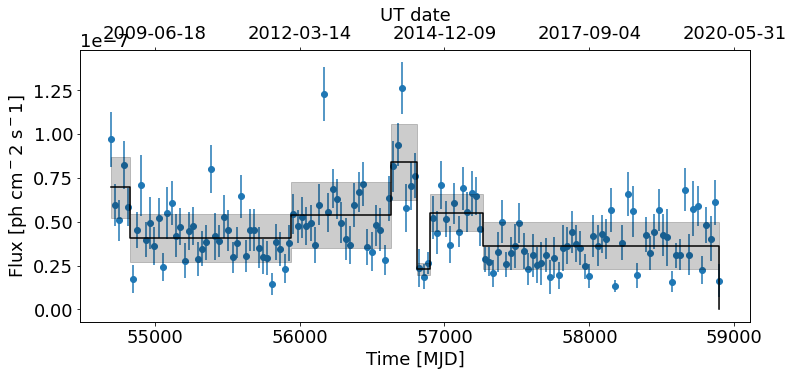

In [17]:
bayesian_block(lc_file, ax=None, p0=2.7e-3, figsize=(12,5), showUT=True, UTfontsize=18, 
                   scale=1.0, ylabel=r"Flux [ph cm$^-2$ s$^-1$]")

# flux distribution

In [18]:
def normal(x, mu, sigma):
    return stats.norm.pdf(x, loc=mu, scale=sigma)

def binormal(x, mu1, sigma1, mu2, sigma2):
    return normal(x, mu1, sigma1) + normal(x, mu2, sigma2)

def lognormal(x, mu, sigma):
    return stats.lognorm.pdf(x, sigma, scale=np.exp(mu))

def bilognormal(x, mu1, sigma1, mu2, sigma2):
    return lognormal(x, mu1, sigma1) + lognormal(x, mu2, sigma2)

# Stochastic model of Tavecchio, Bonnoli, & Galanti (2020)
# as defined in Appendix A
def tbg20(x, mu, lmbda):
    # Perform the computation in log space to avoid overflow errors
    log_numerator = (1 + lmbda)*np.log(lmbda*mu) - special.gammaln(1 + lmbda) - lmbda*mu/x
    denominator = x**(lmbda + 2)
    return np.exp(log_numerator) / denominator

def chisquare(obs, exp, err, num_parameters=None):
    """Compute the reduced chi^2 fit to the model.
    
    See https://www.astroml.org/book_figures/chapter4/fig_chi2_eval.html
    """
    num_counts = len(obs)
    if num_parameters is None:
        num_parameters = 0
    
    z = (obs - exp) / err
    chi2 = np.sum(z**2)
    chi2dof = chi2 / (num_counts - num_parameters)
    sigma = np.sqrt(2. / (num_counts - 1))
    nsig = (chi2dof - 1) / sigma
    return chi2dof, nsig

# Method used by Meyer, Scargle, & Blandford (2019) to calculate the errors on the histogram bins
# See footnote 10 on page 7 of that paper
def bin_errors(flux, flux_err, bin_edges):
    """Calculate bin errors assuming the fluxes are distributed as Gaussians"""
    
    def erf_term(f):
        return special.erf((f - flux[:, None]) / np.sqrt(2 * flux_err[:, None]**2))
    
    F_lo, F_hi = bin_edges[:-1], bin_edges[1:]
    prob = 0.5*(erf_term(F_hi) - erf_term(F_lo))
    return np.sum(prob*(1 - prob), axis=0)


def bootstrap_errors(flux, flux_err, bin_edges):
    """Calculate bin errors using bootstrapping"""
    np.random.seed(0)
    num_samples = len(flux)
    num_bootstraps = 2500
    indices = np.arange(num_samples)
    samples = np.random.choice(indices, (num_samples, num_bootstraps))
    sim_fluxes = np.random.normal(flux[samples], flux_err[samples])
    sim_fluxes = np.clip(sim_fluxes, 1e-10, np.inf)
    sim_hists = np.zeros((len(bin_edges) - 1, num_bootstraps))
    for j in range(num_bootstraps):
        sim_hists[:, j] = np.histogram(sim_fluxes[:, j], bins=bin_edges)[0]
    sim_errs = np.std(sim_hists, axis=1)
    return sim_errs

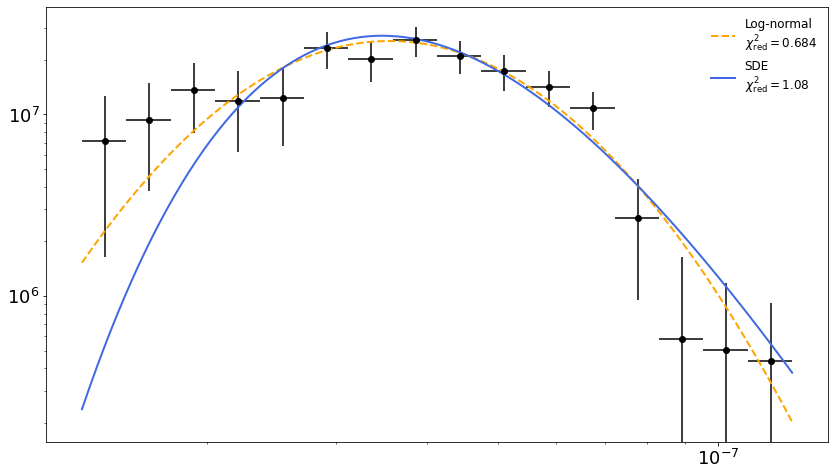

In [41]:
dists = []

def _init():
    global dists 
    dists = [('Log-normal', lognormal, ('mu', 'sigma'), (0.02, 0.2)), 
             ('SDE', tbg20, ('mu', 'lambda'), (5, 0.5))]

fit_params = {}

_init()

flux_norm = 4e-9  # ph cm^-2 s^-1


__, bin_edges = np.histogram(np.log10(flux/flux_norm), bins=16)

hist, bin_edges = np.histogram(flux/flux_norm, bins=10**bin_edges, density=True)
hist_bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist_bin_sizes = np.diff(bin_edges) / 2
hist_errs = bootstrap_errors(flux/flux_norm, flux_error/flux_norm, bin_edges) / np.diff(bin_edges) / len(flux)

plt.errorbar(hist_bin_centers*flux_norm, hist/flux_norm,
                 xerr=hist_bin_sizes*flux_norm, yerr=hist_errs/flux_norm,
                 marker='o', linestyle='none', color='k')

fit_params[source_name] = {}
styles = [{'linestyle': '--', 'color': 'orange'}, {'linestyle': '-', 'color': 'royalblue'}]
for (name, pdf, param_names, p0), style in zip(dists, styles):
    params, pcov = optimize.curve_fit(pdf, hist_bin_centers, hist, p0=p0,
                                     bounds=((1e-8, 0), (np.inf, np.inf)),
                                     sigma=hist_errs, absolute_sigma=True)
    for j, (param_name, param) in enumerate(zip(param_names, params)):
        dic = fit_params[source_name].setdefault(name, {})
        dic[param_name] = param
        dic[param_name + '_err'] = np.sqrt(np.diag(pcov))[j]
    x = np.logspace(np.log10(bin_edges[0]), np.log10(bin_edges[-1]), 100)
    chi2, sigma = chisquare(hist, pdf(hist_bin_centers, *params), hist_errs,
                            num_parameters=len(params))
    label = "{}\n$\chi_{{\mathrm{{red}}}}^2=${:.03}".format(name, chi2)
    plt.plot(x*flux_norm, pdf(x, *params)/flux_norm, linewidth=2, label=label, **style)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=12, frameon=False)
